# 🔗 Linear Regression Model

## 👽 Load and Summarize

In [9]:
# Required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# !pip install --upgrade pandas
import pandas as pd
# print(pd.__version__) # I am having trouble with pandas and dataframes...
import seaborn as sns
# print(sns.__version__)  # Should be 0.11.0 or higher so that `histplot() works
# !pip install --upgrade seaborn
from sklearn.feature_selection import VarianceThreshold

# Load the data
data = pd.read_csv('./data/train_data.csv')

# print(data.shape)
# data.describe()

## 🧯 Suppress the `FutureWarning`

In [8]:
# import warnings
# warnings.simplefilter("ignore", category=FutureWarning)

## 🧼 Clean the Dataset

In [10]:
# # Convert all object columns to strings
cols = ['protocol_type', 'service', 'flag', 'class']

data[cols] = data[cols].astype(str)

data = data.dropna()

# print((data['is_host_login'] == 1).count()) # 25192 empty, so I will drop
# Drop `is_host_login`

# Search for bad columns
constant_cols = [col for col in data.columns if data[col].nunique(dropna=False) == 1]
# print("Useless columns:", constant_cols)  Useless columns: ['num_outbound_cmds', 'is_host_login']
# "Let it all drop" - Modest Mouse
data = data.drop(columns=constant_cols)

# print(data.dtypes)

# Convert the label column
data['class'] = data['class'].map({'normal': 0, 'anomaly': 1})


# Get the binary columns for logistic regression
binary_cols = []

# Get the numeric clumns
numeric_cols = data.select_dtypes(include='number').columns

for col in data.select_dtypes(include='number').columns:
    unique_vals = sorted(data[col].dropna().unique())
    if unique_vals == [0, 1]:
        binary_cols.append(col)

# print("Binary columns:", binary_cols)
binary_cols.remove('num_shells')
# print(binary_cols)
# Separate the numeric and binary columns

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

## 🐫 Removing Low Variance Cells

In [11]:
# Fit the selector
selector = VarianceThreshold(threshold=0.001)
selector.fit(data[numeric_cols])  # call .fit() before accessing .variances_

# Now safe to access .variances_
low_variance = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.00001]

print("Low-variance features:\n" + "-" * 100)
print(low_variance)

if low_variance:
    print("-" * 100)
    print(data[low_variance].describe())
    print("-" * 100)
    print(data.groupby('class')[low_variance].mean())
else:
    print("No low-variance features found.")

Low-variance features:
----------------------------------------------------------------------------------------------------
[]
No low-variance features found.


In [5]:
# Drop these rows because they don't help
# data = data.drop(columns=low_variance) # I am going to keep them for the moment

## 🍧 Build the Linear Model

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
X = data[numeric_cols]
y = data['class']  # Tell me y, ain't nothin' but a heartbreak

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069) # Nice

print(X)

       duration  src_bytes  dst_bytes  wrong_fragment  hot  num_failed_logins  \
0             0        491          0               0    0                  0   
1             0        146          0               0    0                  0   
2             0          0          0               0    0                  0   
3             0        232       8153               0    0                  0   
4             0        199        420               0    0                  0   
...         ...        ...        ...             ...  ...                ...   
25187         0          0          0               0    0                  0   
25188         0        334          0               0    0                  0   
25189         0          0          0               0    0                  0   
25190         0          0          0               0    0                  0   
25191         0          0          0               0    0                  0   

       num_compromised  su_

### 🚂 Train the Model

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 🐊 Evaluate the Model

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_pred_train = (model.predict(X_train) > 0.5).astype(int) # Because we're linear on a classification problem
y_pred_test = (model.predict(X_test) > 0.5).astype(int) # Because we're linear on a classification problem
# Look, it's not perfect, but I am trying to set a baseline...


# Evaluation
print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²:", r2_score(y_test, y_pred_test))
print("Train RMSE:", mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))
print("-" * 100)
# For training data
print("Train classification report:")
print(classification_report(y_train, y_pred_train.round()))
print("-" * 100)
# For test data
print("Test classification report:")
print(classification_report(y_test, y_pred_test.round()))

Train R²: 0.7853787202690982
Test R²: 0.7690146303959049
Train RMSE: 0.2310661260489181
Test RMSE: 0.23989810630559325
----------------------------------------------------------------------------------------------------
Train classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10783
           1       0.95      0.94      0.94      9370

    accuracy                           0.95     20153
   macro avg       0.95      0.95      0.95     20153
weighted avg       0.95      0.95      0.95     20153

----------------------------------------------------------------------------------------------------
Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2666
           1       0.95      0.93      0.94      2373

    accuracy                           0.94      5039
   macro avg       0.94      0.94      0.94      5039
weighted avg       0.94

### 🦖 Confusion Matrix

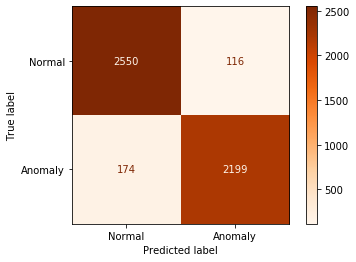

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly']
)

# Plot it
disp.plot(cmap='Oranges')